In [1]:
import torch
import torchvision

In [2]:
from fastai.vision import *

In [135]:
import struct

class MnistDataset(torch.utils.data.Dataset):
    """Mnist dataset."""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample, target = self.images[idx], self.labels[idx]
        sample = np.divide(sample, 255.0)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target
    
    @classmethod
    def load(cls, images_path, labels_path, valid_percent=0.25, transform=None, need_stats=False):
        images = None
        labels = None
        with open(images_path, 'rb') as f:
            fb_data = f.read()

            offset = 0
            fmt_header = '>iiii'    # 以大端法读取4个 unsinged int32
            magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, fb_data, offset)
            offset += struct.calcsize(fmt_header)
            fmt_image = '>' + str(num_rows * num_cols) + 'B'
            images = np.empty((num_images, num_rows, num_cols), dtype=np.float) # 不需要补channel transforms.ToTensor会补
            for i in range(num_images):
                im = struct.unpack_from(fmt_image, fb_data, offset)
                images[i] = np.array(im).reshape((num_rows, num_cols))
                offset += struct.calcsize(fmt_image)
            
        with open(labels_path, 'rb') as f:
            fb_data = f.read()

            offset = 0
            fmt_header = '>ii'    # 以大端法读取2个 unsinged int32
            magic_number, num_labels = struct.unpack_from(fmt_header, fb_data, offset)
            offset += struct.calcsize(fmt_header)
            fmt_image = '>' + str(num_labels) + 'B'
            labels = struct.unpack_from(fmt_image, fb_data, offset)
            labels = np.array(labels)
        
        num_of_train = round(images.shape[0]*(1-valid_percent))
        train_ds = cls(images[:num_of_train], labels[:num_of_train], transform)
        if num_of_train != images.shape[0]: 
            valid_ds = cls(images[num_of_train:], labels[num_of_train:], transform) 
        else:
            valid_ds = None
        result = {'train': train_ds, 'valid': valid_ds}
        if need_stats:
            mean = images.mean()
            std = images.std()
            result['stats'] = [mean, std]
        return result

In [136]:
path = Path('../../data/mnist-raw/')

In [137]:
path.ls()

[PosixPath('../../data/mnist-raw/train-images-idx3-ubyte'),
 PosixPath('../../data/mnist-raw/train-images-idx3-ubyte.gz'),
 PosixPath('../../data/mnist-raw/train-labels-idx1-ubyte.gz'),
 PosixPath('../../data/mnist-raw/train-labels-idx1-ubyte')]

# 计算统计指标
fastai库中也有mnist的统计指标mnist_stats

In [160]:
datasets = MnistDataset.load(path/'train-images-idx3-ubyte', path/'train-labels-idx1-ubyte', 
                             valid_percent=0.25, 
                             transform=torchvision.transforms.ToTensor(), 
                             need_stats=True)
print(f'mean: {datasets["stats"][0]/255.0}, std: {datasets["stats"][1]/255.0}')

mean: 0.1306604762738429, std: 0.30810780385646264


In [161]:
loader = torch.utils.data.DataLoader(datasets['train'], 
                                     batch_size=8,
                                     shuffle=False, 
                                     num_workers=0)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

'''
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean((0, 2))
mean = mean / len(loader.dataset)*8.0 # 由于for循环已经把每个batch的mean计算过了所以应该是mean/(len/batch_size)，等同于mean/len*batch_size
'''

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*28*28))
print(mean, std)

tensor([0.1310], dtype=torch.float64) tensor([0.3086], dtype=torch.float64)


# 准备数据

In [198]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.131], [0.308])
    ]),
    'valid': torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.131], [0.308])
    ]),
}

In [199]:
datasets = MnistDataset.load(path/'train-images-idx3-ubyte', path/'train-labels-idx1-ubyte', 
                             valid_percent=0.25,
                             transform=data_transforms['train'])

In [200]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

In [201]:
inputs, classes = next(iter(dataloaders['train']))

# 可视化

(2, 2)


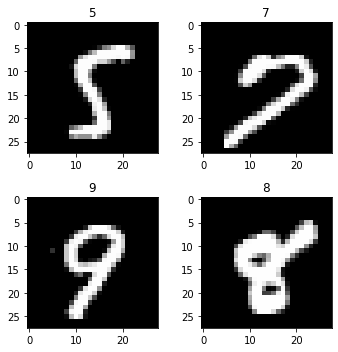

In [202]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
print(axs.shape)
for i, axi in enumerate(axs.flat):
    data = inputs[i][0]*0.308+0.131 #denormalize
    axi.imshow(data, cmap=plt.cm.gray)
    axi.set_title(f'{classes[i]}')
plt.tight_layout() #调整子图间距

# 使用fastai

In [ ]:
class WrapDataset:
    __init__(self)

In [203]:
train_x = ItemList(datasets['train'])
train_y = ItemList(datasets['train'])
train_ll = LabelList(train_x, train_y)

In [192]:
valid_x = ItemList(datasets['valid'][0])
valid_y = ItemList(datasets['valid'][1])
valid_ll = LabelList(train_x, train_y)

In [196]:
data = LabelLists(path, train_ll, valid_ll).databunch(bs=16, num_workers=0)

You can deactivate this warning by passing `no_check=True`.


/opt/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/basic_data.py:248: UserWarning: Your training dataloader is empty, you have only 2 items in your training set.
                 Your batch size is 16, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


In [197]:
len(train_x)

2

# 使用pytorch

# 总结

custom transform提上日程